# Integrating scCAT-seq cell lines

## Imports

In [16]:
# Biology
import scanpy as sc
import anndata as ad
import muon as mu

In [17]:
# Maths
import pandas as pd
import numpy as np
import torch
from torch import optim
from umap import UMAP

In [18]:
# Our packages
from scmiot import models, pl, tl

In [19]:
# Plotting
import matplotlib.pyplot as plt

## Load data

Load the Liu cell lines dataset, which contains 3 well separated cell lines profiled with scRNA-seq and scATAC-seq.

In [20]:
mdata = mu.read_h5mu('../datasets/Liu/preprocessed/liu.h5mu.gz')
rna = mdata.mod['rna']
atac = mdata.mod['atac']

## Selecting highly variable features

For computational reasons, in this simple demonstration we reduce the number of features a lot.

In [21]:
# Highly variable genes
sc.pp.highly_variable_genes(rna, min_mean=0.2, max_mean=4, min_disp=0.5, n_top_genes=500)

# Highly variable peaks
sc.pp.highly_variable_genes(atac, min_mean=1e-5, max_mean=4, min_disp=1, n_top_genes=500)

## Visualize independant modalities

Let us visualize the cell lines independantly using UMAP projections.

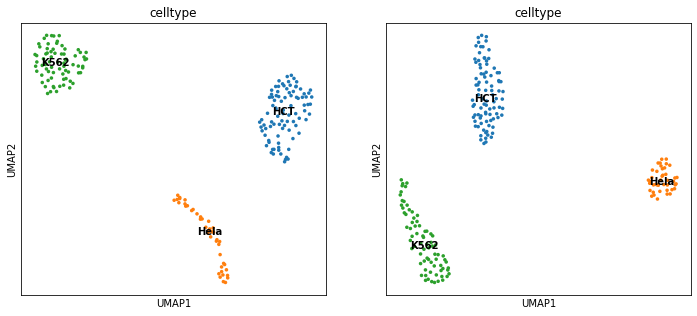

In [22]:
# Umap RNA
sc.pp.scale(rna, zero_center=False)
sc.tl.pca(rna, svd_solver='arpack')
sc.pp.neighbors(rna, n_neighbors=10, n_pcs=10)
sc.tl.umap(rna, spread=1.5, min_dist=.5)

# Umap ATAC
sc.pp.scale(atac, zero_center=False)
sc.tl.pca(atac, svd_solver='arpack')
sc.pp.neighbors(atac, n_neighbors=10, n_pcs=10)
sc.tl.umap(atac, spread=1.5, min_dist=.5)

# Display UMAP
fig, axes = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(12)
sc.pl.umap(rna, color="celltype", legend_loc="on data", size=50, show=False, ax=axes[0])
sc.pl.umap(atac, color="celltype", legend_loc="on data", size=50, show=False, ax=axes[1])
plt.show()

## Perform NMF

Let us define the model and perform the dimensionaly reduction.

In [23]:
# Set the hyperparameters.
eps = .1
latent_dim = 3
rho_h = .1
rho_w = .1

In [24]:
# Define the model.
nmf = models.OTintNMF(latent_dim=latent_dim, rho_h=rho_h, rho_w=rho_w, eps=eps, cost='cosine')

In [25]:
# Perform the training.
nmf.fit_transform(
    mdata, max_iter_inner=1_000, max_iter=100,
    device='cpu', dtype=torch.float, lr=1,
    tol_inner=1e-12, tol_outer=1e-5)

  8%|▊         | 16/200 [00:26<05:10,  1.69s/it, loss=-0.555611, loss_inner=0.36930126, inner_steps=38, gpu_memory_allocated=0]


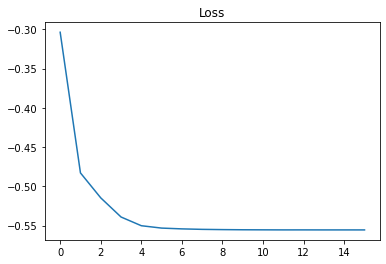

In [26]:
# Display the training loss.
plt.title('Loss')
plt.plot(nmf.losses)
plt.show()

## Visualize the embedding

Now, let us display the obtained embedding.

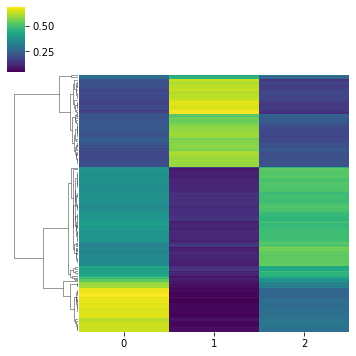

In [27]:
# First, using a dendogram.
pl.clustermap(mdata, 'W_OT', yticklabels=False, figsize=(5, 5), col_cluster=False)

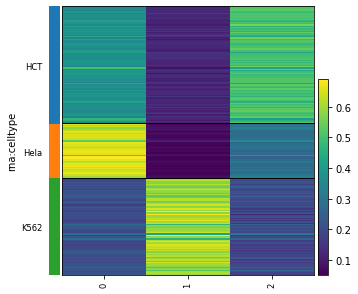

In [28]:
# Then, using the ground truth clusters.
pl.heatmap(mdata, 'W_OT', 'rna:celltype', figsize=(5, 5))

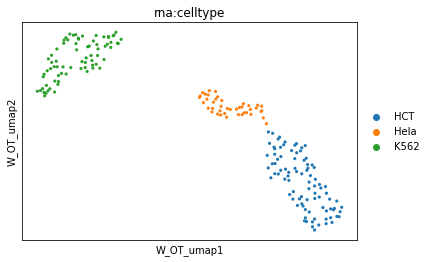

In [29]:
# Finally, we can compute an UMAP embedding and display it.
tl.umap(mdata, 'W_OT', metric='l1', min_dist=.6, spread=1)
mu.pl.embedding(mdata, 'W_OT_umap', 'rna:celltype', size=40)

## Analyse a given factor

We can zoom in on a particular factor to interpret it biologically.

In [30]:
# Display the 3 highest contributors to dimension 0, for ATAC-seq.
tl.top_features(mdata, 'atac', 'H_OT', dim=0, n_features=3)

['Hela_peak_51891b', 'Hela_peak_17554e', 'Hela_peak_98277b']

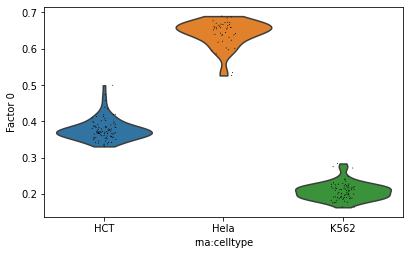

In [31]:
# Display a violoin plot of the value at dimension 0 of the cells.
pl.factor_violin(mdata, groupby='rna:celltype', dim=0)

## Clustering

We can perform clustering on the lower-dimensional space.

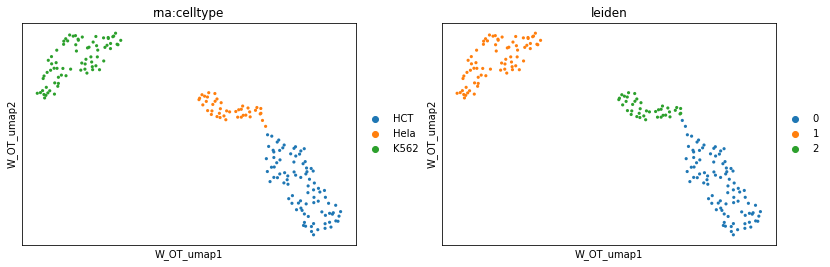

In [34]:
tl.leiden(mdata, resolution=.1)
mu.pl.embedding(mdata, 'W_OT_umap', ['rna:celltype', 'leiden'], size=40)

## Choose best K

Here we display the cosine similarity between the different factors, for different ranks of factorization.

In [35]:
H_list = []
kk = [2, 3, 4, 5, 6, 7]

for k in kk:
    nmf.update_latent_dim(k)
    nmf.fit_transform(
        mdata, max_iter_inner=1_000, max_iter=100,
        device='cpu', dtype=torch.float, lr=1,
        tol_inner=1e-9, tol_outer=1e-5)
    
    H_list.append(nmf.H['rna'])

  6%|▌         | 12/200 [00:35<09:12,  2.94s/it, loss=-0.58885235, loss_inner=0.34524828, inner_steps=210, gpu_memory_allocated=0]


In [36]:
pl.riverplot(H_list, threshold=.75)

You can observe that three is the optimal factorization rank, since the other factors do not add any extra information.